ref. https://www.kaggle.com/c/data-science-london-scikit-learn/discussion/34115

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文(for Mac)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#### READING OUR GIVEN DATA INTO PANDAS DATAFRAME ####
x_train = pd.read_csv('./input/train.csv',header=None)
y_train = pd.read_csv('./input/trainLabels.csv',header=None)
x_test = pd.read_csv('./input/test.csv',header=None)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_train = y_train.ravel()
print('training_x Shape:',x_train.shape,
      ',training_y Shape:',y_train.shape, 
      ',testing_x Shape:',x_test.shape )
print('training_x len:',len(x_train),
      ',training_y len:',len(y_train), 
      ',testing_x len:',len(x_test) )


training_x Shape: (1000, 40) ,training_y Shape: (1000,) ,testing_x Shape: (9000, 40)
training_x len: 1000 ,training_y len: 1000 ,testing_x len: 9000


In [4]:
print(x_train[0:2])

[[ 0.29940251 -1.22662419  1.49842505 -1.17615036  5.28985255  0.20829711
   2.40449837  1.59450622 -0.05160816  0.66323431 -1.40837006  1.11474364
   0.91041531  2.21811032  4.30564273  0.08892398  0.16914926  0.41344764
   1.51386217  2.66296658 -1.07276548  0.14911112  0.55957919  4.37888464
  -0.46360266 -0.06395916  0.54493031  0.71277167 -1.49405013 -2.63616888
  -0.85046545 -0.62299    -1.83305734  0.29302439  3.55268134  0.71761099
   3.30597197 -2.71555881 -2.68240859  0.10105047]
 [-1.17417585  0.33215734  0.94991875 -1.28532757  2.1990606  -0.15126803
  -0.42703874  2.61924614 -0.76588383 -0.09378022  0.93534681  1.05779589
  -0.53927514 -0.17266152 -0.67905149  0.60736159  1.14863456  2.43707734
  -0.31306854  0.52810423 -0.51347562  0.76622141 -1.46693926 -2.31888533
   1.64722315 -1.55644281 -1.64558052 -0.19846661 -1.4720664  -1.9061467
  -0.81975023  0.01203661  2.03883565  0.46857886 -0.51765687  0.42232569
   0.8036988   1.21321926  1.38293163 -1.81776106]]


In [5]:
print(x_test[0:2])

[[ 2.80890949 -0.24289415 -0.54642134  0.25516186  1.74973594 -0.03045761
  -1.32207056  3.57807068 -0.66757846 -0.88425685 -0.24779664  1.52706835
   3.35996311  1.17249959  1.82386451  0.0323646  -0.50647429  0.11677482
   0.30279634 -0.06967659 -1.06765242  0.26885488 -2.11481596 -2.82996625
  -0.37952031  2.4982891  -0.94309463  0.82602315  0.7383525  -1.25024433
  -0.26168811 -0.22437539 -1.67560552 -0.47958361 -0.24438815 -0.67235457
   0.51786002  0.01066468 -0.41921433  2.8183871 ]
 [-0.3741013   0.53766912  0.08106285  0.75677252  0.91523096  2.55728154
   3.70318686  1.67383494 -0.76412214 -1.22803958 -0.39214144  0.39640554
  -6.40420143  0.89278208 -0.27707687 -2.27700223  0.02014226  0.24474578
  -3.12953255  0.64621516  0.59603327 -0.18385815 -1.72483972 -4.74464083
   0.7355395   1.98714871  0.30861132  0.19170014 -3.30926621 -1.47418552
  -0.96946325  0.57415392 -2.20051919 -1.61223966  0.17903131 -2.92459575
   0.64361025 -1.47093888 -0.06740834 -0.97626498]]


In [6]:
#Checking the models
x_all = np.r_[x_train,x_test]
print('x_all shape :',x_all.shape)

x_all shape : (10000, 40)


**Gaussian mixture model:** http://scikit-learn.org/stable/modules/mixture.html

**'full'** (each component has its own general covariance matrix),

**'tied'** (all components share the same general covariance matrix),

**'diag'** (each component has its own diagonal covariance matrix),

**'spherical'** (each component has its own single variance).

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_covariances_0011.png)

In [7]:
#### USING THE GAUSSIAN MIXTURE MODEL ####
from sklearn.mixture import GaussianMixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
    # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(x_all)
        bic.append(gmm.aic(x_all))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

best_gmm.fit(x_all)
x_train = best_gmm.predict_proba(x_train)
x_test = best_gmm.predict_proba(x_test)

In [8]:
print(x_train[0:2])

[[  1.62832825e-030   2.07210903e-305   8.11400618e-089   1.00000000e+000]
 [  1.00000000e+000   1.69233847e-019   1.89134075e-064   1.81880592e-083]]


In [9]:
print(x_test[0:2])

[[  1.57635942e-020   3.70448521e-019   0.00000000e+000   1.00000000e+000]
 [  1.00000000e+000   7.21957951e-070   2.67858950e-230   2.23981272e-126]]


In [10]:
x_train[0:2,0]

array([  1.62832825e-30,   1.00000000e+00])

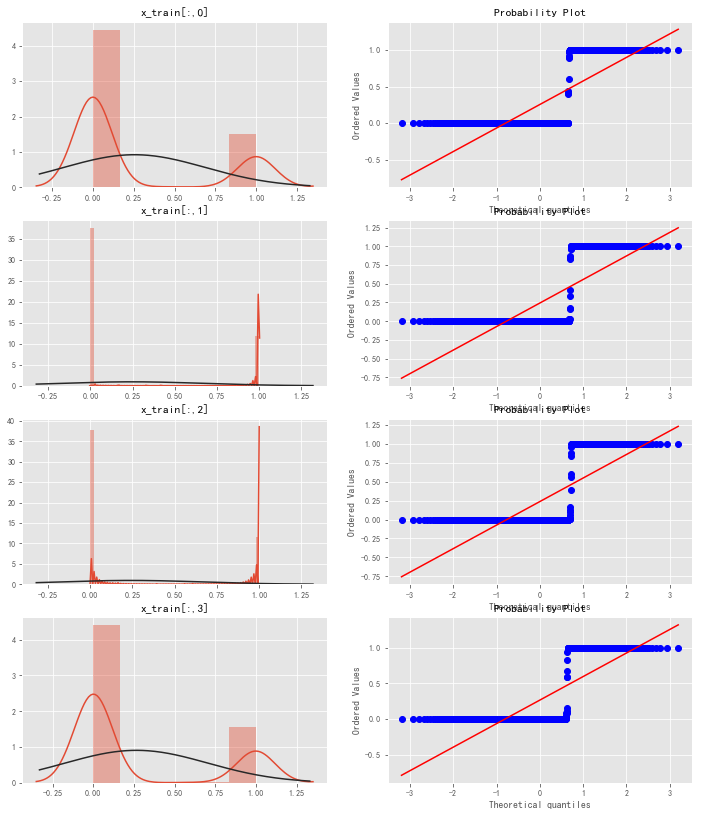

In [11]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

#histogram and normal probability plot
plt.figure(figsize=(12, 14))
plt.rcParams['axes.unicode_minus']=False #正常顯示負號
plt.rcParams['font.size']=8

plt.subplot(4,2,1)
plt.title('x_train[:,0]')
sns.distplot(x_train[:,0], fit=norm);
plt.subplot(4,2,2)
res = stats.probplot(x_train[:,0], plot=plt)

plt.subplot(4,2,3)
plt.title('x_train[:,1]')
sns.distplot(x_train[:,1], fit=norm);
plt.subplot(4,2,4)
res = stats.probplot(x_train[:,1], plot=plt)

plt.subplot(4,2,5)
plt.title('x_train[:,2]')
sns.distplot(x_train[:,2], fit=norm);
plt.subplot(4,2,6)
res = stats.probplot(x_train[:,2], plot=plt)

plt.subplot(4,2,7)
plt.title('x_train[:,3]')
sns.distplot(x_train[:,3], fit=norm);
plt.subplot(4,2,8)
res = stats.probplot(x_train[:,3], plot=plt)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier
#from sklearn import svm
from sklearn.cross_validation import cross_val_score

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
#### TAKING ONLY TWO MODELS FOR KEEPING IT SIMPLE ####
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [14]:
param_grid = dict( )
#### GRID SEARCH for BEST TUNING PARAMETERS FOR KNN #####
grid_search_knn = GridSearchCV(knn,param_grid=param_grid,cv=10,scoring='accuracy').fit(x_train,y_train)
print('best estimator KNN:',grid_search_knn.best_estimator_,
      'Best Score', grid_search_knn.best_estimator_.score(x_train,y_train))
knn_best = grid_search_knn.best_estimator_

best estimator KNN: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') Best Score 0.996


In [15]:
#### GRID SEARCH for BEST TUNING PARAMETERS FOR RandomForest #####
grid_search_rf = GridSearchCV(rf, param_grid=dict( ), verbose=3,scoring='accuracy',cv=10).fit(x_train,y_train)
print('best estimator RandomForest:',grid_search_rf.best_estimator_,
      'Best Score', grid_search_rf.best_estimator_.score(x_train,y_train))
rf_best = grid_search_rf.best_estimator_

knn_best.fit(x_train,y_train)
print("KNN:",knn_best.predict(x_test)[0:10])
rf_best.fit(x_train,y_train)
print("RF:",rf_best.predict(x_test)[0:10])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.990000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....................................... , score=0.990000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=1.000000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.980000 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.990000 -   0.0s
best estimator RandomForest: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Best Score 0.997
KNN: [1 0 1 0 0 0 0 1 0 0]
RF: [1 0 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [16]:
#### SCORING THE MODELS ####
print('Score for KNN :',cross_val_score(knn_best,x_train,y_train,cv=10,scoring='accuracy').mean())
print('Score for Random Forest :',cross_val_score(rf_best,x_train,y_train,cv=10,scoring='accuracy').max())

Score for KNN : 0.996
Score for Random Forest : 1.0


In [17]:
### IN CASE WE WERE USING MORE THAN ONE CLASSIFIERS THEN VOTING CLASSIFIER CAN BE USEFUL ###
#clf = VotingClassifier(
#       estimators=[('knn_best',knn_best),('rf_best',rf_best)],
#       #weights=[871856020222,0.907895269918]
#      )
#clf.fit(x_train,y_train)
#print("Votting:",clf.predict(x_test)[0:10])

In [18]:
##### FRAMING OUR SOLUTION #####
knn_best_pred = knn_best.predict(x_test)
rf_best_pred = rf_best.predict(x_test)
#voting_clf_pred = pd.DataFrame(clf.predict(x_test))

In [19]:
row_id = [i for i in range(1,9001)]

In [20]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'Id': row_id, 'Solution': rf_best_pred })[["Id","Solution"]]
StackingSubmission.to_csv("submission_PCA_GMM.csv", index=False)

In [21]:
##LB score: 0.99105